                                                Assignment-2

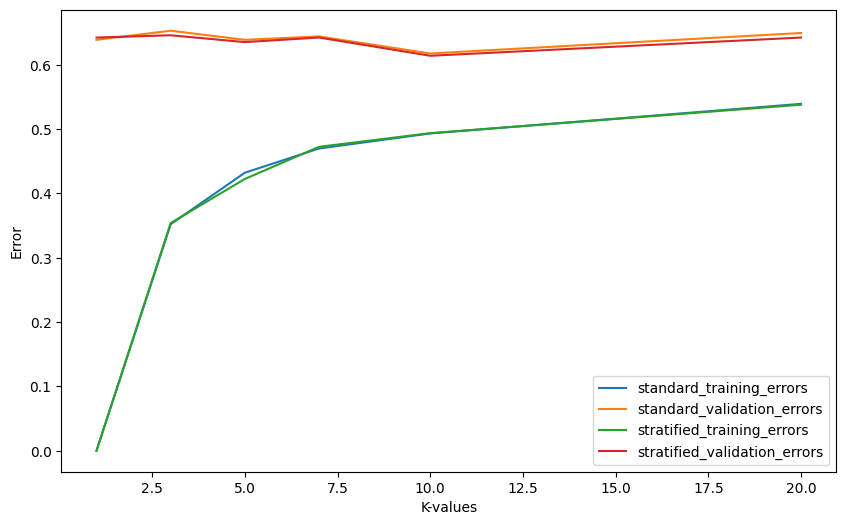

10
0.676056338028169
MLPClassifier(hidden_layer_sizes=(10, 10, 10))


              precision    recall  f1-score   support

           0       0.41      0.37      0.39        30
           1       0.23      0.15      0.18        33
           2       0.31      0.32      0.32        34
           3       0.28      0.36      0.31        45

    accuracy                           0.30       142
   macro avg       0.31      0.30      0.30       142
weighted avg       0.30      0.30      0.30       142

mean validation :0.39823008849557523


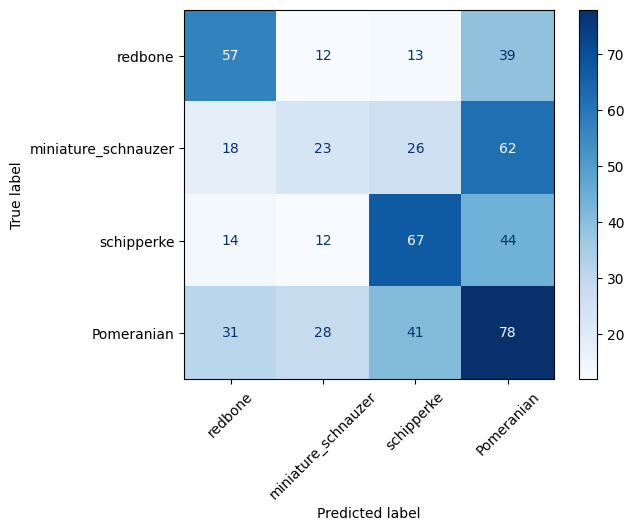

DecisionTreeClassifier(max_depth=10)


              precision    recall  f1-score   support

           0       0.29      0.20      0.24        30
           1       0.28      0.24      0.26        33
           2       0.37      0.44      0.40        34
           3       0.25      0.29      0.27        45

    accuracy                           0.30       142
   macro avg       0.30      0.29      0.29       142
weighted avg       0.29      0.30      0.29       142

mean validation :0.32035398230088497


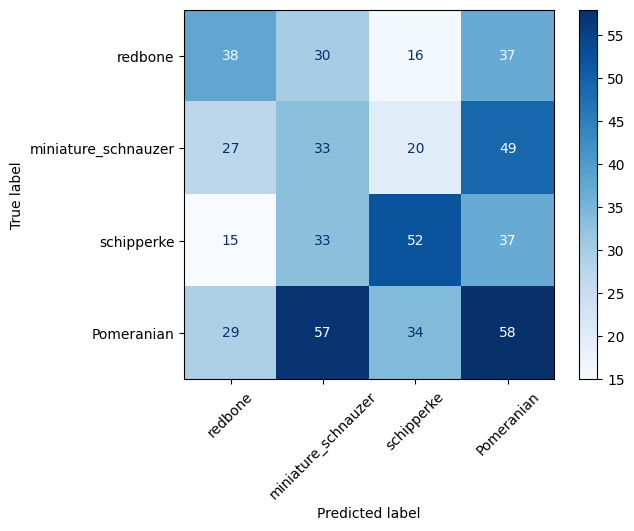

RandomForestClassifier()


              precision    recall  f1-score   support

           0       0.38      0.33      0.36        30
           1       0.11      0.06      0.08        33
           2       0.52      0.41      0.46        34
           3       0.30      0.47      0.36        45

    accuracy                           0.33       142
   macro avg       0.33      0.32      0.31       142
weighted avg       0.32      0.33      0.32       142

mean validation :0.3876106194690266


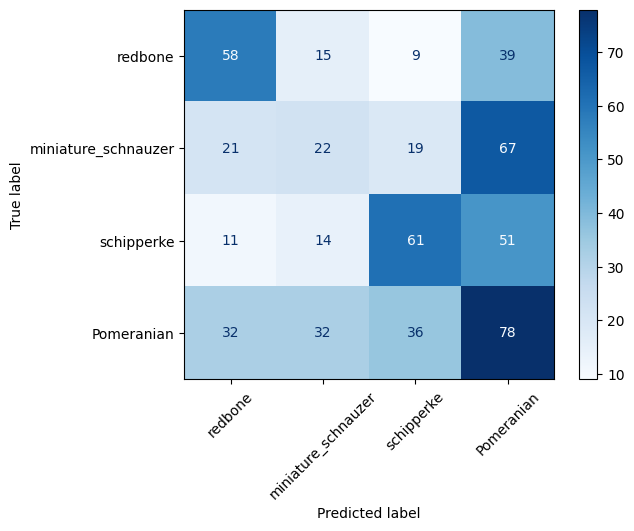

In [19]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold,KFold
from skimage import filters,io,color,exposure
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix,ConfusionMatrixDisplay,classification_report

import warnings 
warnings.filterwarnings("ignore")  


image_dir=r'Cropped'

# image process

def angle(dx, dy):
    return np.mod(np.arctan2(dy, dx), np.pi)


X = []
Y = []
for index,dog in enumerate(os.listdir(image_dir)):
    path=os.path.join(image_dir,dog)
    for file in os.listdir(path):
        img    = io.imread(os.path.join(path,file.strip()))
        gray_img=  color.rgb2gray(img)
        image = angle(filters.sobel_h(gray_img),filters.sobel_v(gray_img))
        hist,_=exposure.histogram(image, nbins=36)
        X.append(hist)
        Y.append(index)
X=np.array(X)
Y=np.array(Y)

# scaling
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42,stratify=Y)
Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)


# model selection

K_values = [1,3,5,7,10,20]



# standard 

standard_training_errors=[]
standard_validation_errors=[]

standardkfold = KFold(n_splits=5)
for k in K_values:
    knn = KNeighborsClassifier(k)    
    train = []
    validation = []
    for traini, testi in standardkfold.split(X_train, y_train):
        xtrain, xval = X_train[traini], X_train[testi]
        ytrain, yval = y_train[traini], y_train[testi]
        knn.fit(xtrain, ytrain)
        trainpred = knn.predict(xtrain)
        valpred = knn.predict(xval)
        train_acc = accuracy_score(ytrain, trainpred)
        val_acc = accuracy_score(yval, valpred)
        train.append(1 - train_acc)  
        validation.append(1 - val_acc) 

    standard_training_errors.append(np.mean(train))
    standard_validation_errors.append(np.mean(validation))



    
    
# stratified

stratified_training_errors=[]
stratified_validation_errors=[]

stratified=StratifiedKFold(n_splits=5)
for k in K_values:
    knn = KNeighborsClassifier(k)    
    train = []
    validation = []
    for traini, testi in stratified.split(X_train, y_train):
        xtrain, xval = X_train[traini], X_train[testi]
        ytrain, yval = y_train[traini], y_train[testi]
        knn.fit(xtrain, ytrain)
        trainpred = knn.predict(xtrain)
        valpred = knn.predict(xval)
        train_acc = accuracy_score(ytrain, trainpred)
        val_acc = accuracy_score(yval, valpred)
        train.append(1 - train_acc)  
        validation.append(1 - val_acc) 

    stratified_training_errors.append(np.mean(train))
    stratified_validation_errors.append(np.mean(validation))

plt.figure(figsize=(10, 6))
plt.plot(K_values, standard_training_errors, label='standard_training_errors')
plt.plot(K_values, standard_validation_errors, label='standard_validation_errors')
plt.plot(K_values, stratified_training_errors, label='stratified_training_errors')
plt.plot(K_values, stratified_validation_errors, label='stratified_validation_errors')
plt.xlabel('K-values')
plt.ylabel('Error')
plt.legend()
plt.show()


sk=K_values[np.argmin(stratified_validation_errors)]
print(sk)
#test error 
model=KNeighborsClassifier(sk)
model.fit(X_train,y_train)
pred=model.predict(X_test)
err=1-accuracy_score(y_test,pred)
print(err)





#performance comparision
methods=[MLPClassifier(hidden_layer_sizes=(10,10,10)),DecisionTreeClassifier(max_depth=10),RandomForestClassifier()]
    
for clf in methods:
    print(str(clf)+"\n\n")
    clf.fit(X_train,y_train)
    predictions=clf.predict(X_test)
    confu_matrix = confusion_matrix(y_test, predictions)
    report=classification_report(y_test,predictions)
    print(report)
    truelabels,predictlabels,cm,val_a=[],[],[],[]
    for traini, testi in stratified.split(X_train, y_train):
        xtrain, xval = X_train[traini], X_train[testi]
        ytrain, yval = y_train[traini], y_train[testi]
        
        clf.fit(xtrain,ytrain)
        p=clf.predict(xval)
        
        truelabels.extend(yval)
        predictlabels.extend(p)
        val_a.append(accuracy_score(yval,p)) 
    print("mean validation :"+str(np.mean(val_a)))
    cm.append(confusion_matrix(truelabels, predictlabels))
    cm_display = ConfusionMatrixDisplay(confusion_matrix = sum(cm)/len(cm), display_labels = ['redbone', 'miniature_schnauzer', 'schipperke', 'Pomeranian'])
    cm_display.plot(cmap=plt.cm.Blues)
    plt.show()



In [21]:
# at k=1 we have lowest mean error for standard and stratified train error,  at k= 10 for standard/stratified validation error 

In [20]:
#low complexity at k=1, between in 3,5,7,10 anf high at k=20

In [22]:
# overfits at k= 1 (less trainign error,more validation error), under fit at k= 20 (more number of neighbors)

In [23]:
# at k= 10 test error : 0.676056338028169

In [24]:
# random forest best based on confusion matrix display , classifying different dogs in more number.

In [25]:
# MLP best based on mean validation accuracy

In [26]:
# random forest best based on Test accuracy 

In [27]:
# random forest best based on f1 score  

Reference :
    https://scikit-image.org/docs/stable/api/skimage.exposure.html
    
     https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html